In [13]:
from PyFoam.Applications.CloneCase import CloneCase
from PyFoam.Applications.ClearCase import ClearCase
from PyFoam.Applications.CreateBoundaryPatches import CreateBoundaryPatches
from PyFoam.Applications.ChangeBoundaryName import ChangeBoundaryName
from PyFoam.Applications.WriteDictionary import WriteDictionary
from PyFoam.Applications.Runner import Runner
import shutil, os

In [14]:
# Assume that we already sourced .bashrc with OpenFOAM-5.0
#openfoam_source = os.path.abspath("/opt/openfoam5/etc/bashrc")
#os.system("source "+openfoam_source)
# Clone case from the existing one
srcpath = os.path.join(os.environ['FOAM_TUTORIALS'],"incompressible/icoFoam/cavity/cavity")
CloneCase(args=["--no-vcs",srcpath,"cavity","--force","--no-pyfoam"])

 PyFoam WARNING on line 109 of file /home/pavel.kholodov/anaconda2/lib/python2.7/site-packages/PyFoam/Applications/CloneCase.py : Replacing cavity (--force option) 


In [15]:
Runner(args=["--silent","--no-server-process","blockMesh","-case","cavity"])

In [16]:
#Change BC name just to test functionality
ChangeBoundaryName(args=["cavity","movingWall","slideWall"])
#CreateBoundaryPatches(args=["--overwrite","--filter=fixedWalls","--default={'type':'fixedValue','value':'uniform (0 0 0)'}","./cavity/0/U"])
#CreateBoundaryPatches(args=["--overwrite","--filter=movingWall","--default={'type':'fixedValue','value':'uniform (1 0 0)'}","./cavity/0/U"])

In [17]:
CreateBoundaryPatches(args=["--clear-unused","--overwrite","./cavity/0/U"])
CreateBoundaryPatches(args=["--clear-unused","--overwrite","./cavity/0/p"])

In [18]:
CreateBoundaryPatches(args=["--overwrite","--filter=fixedWalls","--default={'type':'fixedValue','value':'uniform (0 0 0)'}","./cavity/0/U"])
CreateBoundaryPatches(args=["--overwrite","--filter=slideWall","--default={'type':'fixedValue','value':'uniform (2 0 0)'}","./cavity/0/U"])

In [19]:
WriteDictionary(args=["./cavity/system/controlDict","startTime","0"])
WriteDictionary(args=["./cavity/system/controlDict","endTime","1"])
WriteDictionary(args=["./cavity/system/controlDict","deltaT","0.005"])
WriteDictionary(args=["./cavity/system/controlDict","writeControl","runTime"])
WriteDictionary(args=["./cavity/system/controlDict","writeInterval","0.1"])

In [20]:
# clear previous calculation results and run application
Runner(args=["--complete-clear","--pyfoam-stuff-clear","--silent","--no-server-process","icoFoam","-case","cavity"])

Clearing out old timesteps ....


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/pavel.kholodov/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/pavel.kholodov/anaconda2/lib/python2.7/threading.py", line 1073, in run
    self.function(*self.args, **self.kwargs)
  File "/home/pavel.kholodov/anaconda2/lib/python2.7/site-packages/PyFoam/Execution/FoamThread.py", line 86, in getLinuxMem
    me=psutil.Process(thrd.threadPid)
  File "/home/pavel.kholodov/anaconda2/lib/python2.7/site-packages/psutil/__init__.py", line 364, in __init__
    self._init(pid)
  File "/home/pavel.kholodov/anaconda2/lib/python2.7/site-packages/psutil/__init__.py", line 404, in _init
    raise NoSuchProcess(pid, None, msg)
NoSuchProcess: psutil.NoSuchProcess no process found with pid 13940



In [21]:
# convert OpenFOAM results into legacy VTK format
os.system("foamToVTK -case ./cavity -latestTime -ascii")

0

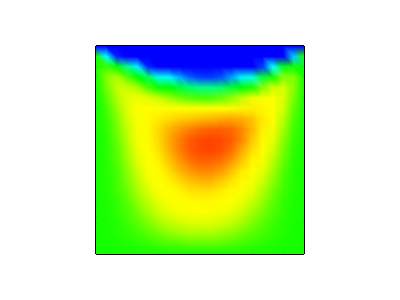

In [6]:
# Post-processing
# Color mesh by scalar value
# Import vtk module
import os
from vtk import *
# Add IPython element to embed window
# Function is taken from https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    # We can also define some camera settings
    #cam = renderer.GetActiveCamera()
    #cam.Azimuth(5.0)
    #cam.Elevation(1.0)
    #cam.Zoom(4.)
    #cam.Pitch(1.)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)
#################################33
# Define path to VTK results file
filename=os.path.join(os.getcwd(),"cavity/VTK/cavity_200.vtk")

# Read the source file.
reader = vtkUnstructuredGridReader()
reader.SetFileName(filename)
reader.Update()
# Define output port (whatever)
reader_out =  reader.GetOutputPort()
# Define mappert
meshMapper = vtkDataSetMapper()
meshMapper.SetInputConnection(reader_out)

# convert to CellData (because OpenFOAM writes VTK results as Field dataset attribute)
# Field represent an array of data arrays, see VTK User's Guide, "VTK File Formats"
# We need to convert it to cell or point Data
# First do for cells
cellData = vtkFieldDataToAttributeDataFilter()
cellData.SetInputConnection(reader.GetOutputPort())
cellData.SetInputFieldToCellDataField()
cellData.SetOutputAttributeDataToCellData()
# Choose whether to normalize results or not
#cellData.DefaultNormalizeOn()
# Define which scalar to show (velocity is also a scalar with 3 components in array)
"""
Hint: to define a scalar one should give 3 arguments (at least)
1) component number, type int - what is it I don't know
2) array name (the name of scalar array which is the name of a scalar to show), type str
3) component in scalar (e.g. in array 'p' there is 1 component; in array 'U' there is 3 components)
"""
#cellData.SetScalarComponent(0, 'U', 0)
##########################################
# Second, do for points
pointData = vtkFieldDataToAttributeDataFilter()
pointData.SetInputConnection(reader.GetOutputPort())
pointData.SetInputFieldToPointDataField()
pointData.SetOutputAttributeDataToPointData()
pointData.SetScalarComponent(0, 'U', 0)
# Define a mapper for our data
res_mapper = vtkDataSetMapper()
# Define a range to show
res_mapper.SetScalarRange(-0.5,0.6)
##################################
#res_mapper.SetInputConnection(cellData.GetOutputPort())
res_mapper.SetInputConnection(pointData.GetOutputPort())
"""
# Define cut plane (XZ plane)
plane = vtk.vtkPlane()
# Origin point
plane.SetOrigin(0.05,0,0.0)
# Normal
plane.SetNormal(1,0,0)

#create cutter
cutter=vtk.vtkCutter()
cutter.SetCutFunction(plane)
cutter.SetInputConnection(reader.GetOutputPort())
cutter.Update()
cutterMapper=vtk.vtkPolyDataMapper()
cutterMapper.SetInputConnection(cutter.GetOutputPort())

# Define plane actor
planeActor = vtk.vtkActor()
# The color of the plane
#planeActor.GetProperty().SetColor(1.0,1,0)
planeActor.GetProperty().SetLineWidth(2)
planeActor.SetMapper(cutterMapper)
"""
# Define actor for results mapper
resActor=vtk.vtkActor()
resActor.SetMapper(res_mapper)
# Define actor for mesh
meshActor=vtk.vtkActor()
# Mesh color in RGB format (0,0,0) - black
meshActor.GetProperty().SetColor(0.0,0.0,0.0)
meshActor.GetProperty().SetLineWidth(2)
# Define mesh opacity
meshActor.GetProperty().SetOpacity(1)
meshActor.SetMapper(meshMapper)
# Define showing regime - Wireframe to draw mesh lines and nothing else
meshActor.GetProperty().SetRepresentationToWireframe()

# A renderer and render window
renderer = vtk.vtkRenderer()
# Define background color in RGB format
renderer.SetBackground(1, 1, 1)

# add the actors
# Plane actor
#renderer.AddActor(planeActor)
# Mesh actor
renderer.AddActor(meshActor)
# Results actor
renderer.AddActor(resActor)
# Define render window (I put it there if we want to render in external OpenGL window)
"""
renwin = vtk.vtkRenderWindow()
renwin.AddRenderer(renderer)
renwin.SetSize(400, 300)

# An interactor
interactor = vtk.vtkRenderWindowInteractor()
# Add render to interactor window
interactor.SetRenderWindow(renwin)
# Start - Will display OpenGL interactive window with all actors
interactor.Initialize()
interactor.Start()
"""
# Show results in IPython window (non-interactively)
vtk_show(renderer,400,300)